In [ ]:
import pandas as pd
import numpy as np
import random
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [ ]:
def extract_binary_columns(dataframe):
    """
    This function takes a pandas DataFrame and returns a list of column names
    that are binary (i.e., they contain only two unique values).

    :param dataframe: Pandas DataFrame with data
    :return: List of names of binary columns
    """
    binary_columns = []
    for column in dataframe.columns:
        # Check if the column has exactly two unique values
        if dataframe[column].nunique() == 2:
            binary_columns.append(column)

    return binary_columns

In [ ]:
# Load the data after Lasso
data_train = pd.read_csv('/content/data_train_lasso.csv')
data_test = pd.read_csv('/content/data_test_lasso.csv')

# training set
X_train = data_train.drop('Disease', axis=1)
y_train = data_train['Disease']
# test set
X_test = data_test.drop('Disease', axis=1)
y_test = data_test['Disease']

categorical_cols = extract_binary_columns(data_train)
numerical_cols = [col for col in data_train.columns if col not in categorical_cols]
data_train_numerical = data_train[numerical_cols]
data_test_numerical = data_test[numerical_cols]

# Create a StandardScaler instance for numerical features
scaler = StandardScaler()
# Fit the scaler on the training data and transform both training and test data for numerical features
data_train_numerical_normalized = scaler.fit_transform(data_train_numerical)
data_test_numerical_normalized = scaler.transform(data_test_numerical)

# Combine the normalized numerical cols with categorical cols
data_train_normalized = pd.concat([pd.DataFrame(data_train_numerical_normalized, columns=numerical_cols), data_train[categorical_cols]], axis=1)
data_test_normalized = pd.concat([pd.DataFrame(data_test_numerical_normalized, columns=numerical_cols), data_test[categorical_cols]], axis=1)

# Prepare datasets
# training set
X_train = data_train_normalized.drop('Disease', axis=1)
y_train = data_train_normalized['Disease']
# test set
X_test = data_test_normalized.drop('Disease', axis=1)
y_test = data_test_normalized['Disease']


# Convert pandas dataframes/numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float) # Use torch.float for regression targets

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float) # Use torch.float for regression targets

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# For demonstration, let's also prepare the test DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)

        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2)

        x = torch.sigmoid(self.fc3(x))
        return x


Epoch 1/60, Train Loss: 0.6703
Epoch 2/60, Train Loss: 0.5722
Epoch 3/60, Train Loss: 0.5318
Epoch 4/60, Train Loss: 0.5160
Epoch 5/60, Train Loss: 0.5101
Epoch 6/60, Train Loss: 0.5037
Epoch 7/60, Train Loss: 0.5054
Epoch 8/60, Train Loss: 0.4859
Epoch 9/60, Train Loss: 0.4919
Epoch 10/60, Train Loss: 0.4679
Epoch 11/60, Train Loss: 0.4858
Epoch 12/60, Train Loss: 0.4757
Epoch 13/60, Train Loss: 0.4642
Epoch 14/60, Train Loss: 0.4612
Epoch 15/60, Train Loss: 0.4393
Epoch 16/60, Train Loss: 0.4446
Epoch 17/60, Train Loss: 0.4323
Epoch 18/60, Train Loss: 0.4330
Epoch 19/60, Train Loss: 0.4199
Epoch 20/60, Train Loss: 0.4280
Epoch 21/60, Train Loss: 0.4298
Epoch 22/60, Train Loss: 0.4258
Epoch 23/60, Train Loss: 0.3996
Epoch 24/60, Train Loss: 0.4138
Epoch 25/60, Train Loss: 0.4098
Epoch 26/60, Train Loss: 0.4031
Epoch 27/60, Train Loss: 0.4075
Epoch 28/60, Train Loss: 0.4104
Epoch 29/60, Train Loss: 0.3792
Epoch 30/60, Train Loss: 0.3959
Epoch 31/60, Train Loss: 0.3713
Epoch 32/60, Trai

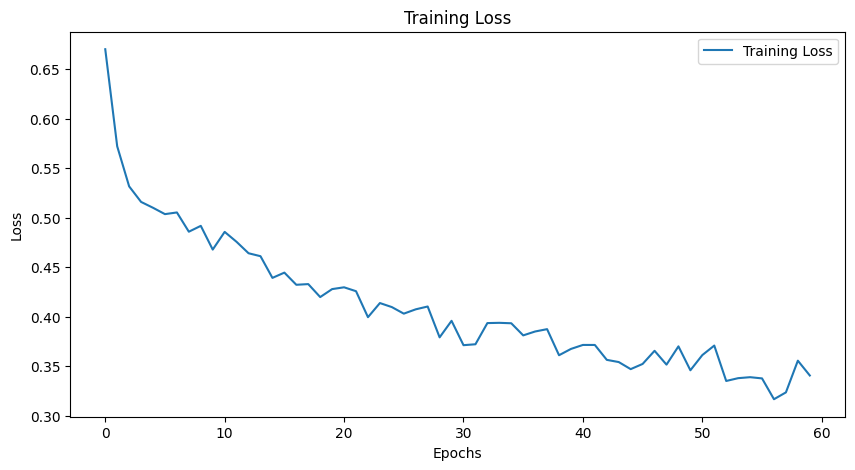

In [ ]:
# Instantiate the model
model = NeuralNet(X_train.shape[1])
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training
num_epochs = 60
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}')

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Function to evaluate the model
def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).squeeze()
        y_pred_numpy = y_pred.numpy()
        y_test_numpy = y_test_tensor.numpy()
    accuracy = roc_auc_score(y_test_numpy, y_pred_numpy)
    return accuracy

# Original accuracy
original_auc = evaluate_model(model, X_test_tensor, y_test_tensor)
print('AUC score =', original_auc)


AUC score = 0.7883317261330762


In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze()
    y_pred_numpy = y_pred.numpy()
    y_test_numpy = y_test_tensor.numpy()

threshold=0.5
predicted_classes = (y_pred_numpy > threshold).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_numpy, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report for additional metrics (including TPR and NPV)
report = classification_report(y_test_numpy, predicted_classes, target_names=['Negative', 'Positive'])
print("Classification Report:")
print(report)

# Manually calculating TPR (Sensitivity) and NPV
TP = conf_matrix[1, 1]  # True Positives
TN = conf_matrix[0, 0]  # True Negatives
FP = conf_matrix[0, 1]  # False Positives
FN = conf_matrix[1, 0]  # False Negatives

TPR = TP / (TP + FN)  # True Positive Rate (Sensitivity)
NPV = TN / (TN + FN)  # Negative Predictive Value

print(f"True Positive Rate (Sensitivity): {TPR:.4f}")
print(f"Negative Predictive Value: {NPV:.4f}")


Confusion Matrix:
[[66 19]
 [25 36]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.73      0.78      0.75        85
    Positive       0.65      0.59      0.62        61

    accuracy                           0.70       146
   macro avg       0.69      0.68      0.69       146
weighted avg       0.70      0.70      0.70       146

True Positive Rate (Sensitivity): 0.5902
Negative Predictive Value: 0.7253


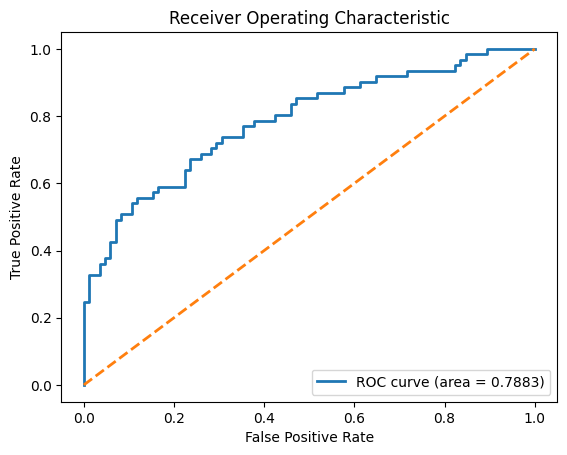

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_numpy, y_pred_numpy)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {original_auc:.4f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
def plot_bootstrap_calibration_curve(y_true, y_pred_proba, n_bootstraps=1000):
    mean_predicted_value = np.linspace(0, 1, 100)
    mean_true_fraction = np.zeros_like(mean_predicted_value)

    # Bootstrap resampling
    for _ in range(n_bootstraps):
        # Resample the dataset
        y_true_resampled, y_pred_resampled = resample(y_true, y_pred_proba)
        true_fraction, predicted_value = calibration_curve(y_true_resampled, y_pred_resampled, n_bins=10)

        # Interpolate to get smoother curve
        mean_true_fraction += np.interp(mean_predicted_value, predicted_value, true_fraction)

    # Averaging over bootstraps
    mean_true_fraction /= n_bootstraps

    # Plotting the calibration curve
    plt.plot(mean_predicted_value, mean_true_fraction, label='Calibration curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()


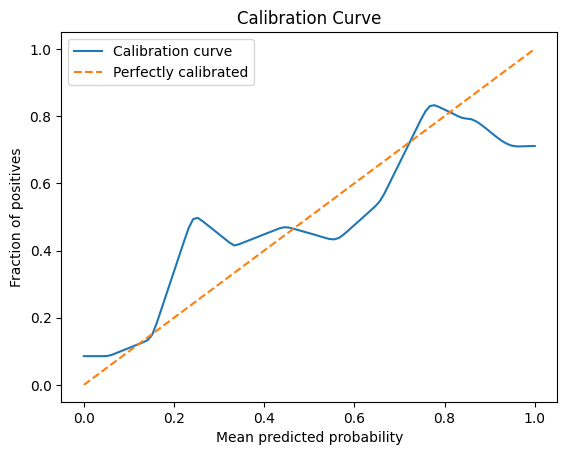

In [ ]:
plot_bootstrap_calibration_curve(y_test_numpy, y_pred_numpy, n_bootstraps=1000)


Performing feature importance ranking in a neural network is not as straightforward as it is with some other machine learning models, like decision trees. Neural networks, especially deep learning models, are often considered "black boxes" due to their complexity and the non-linear transformations they apply.

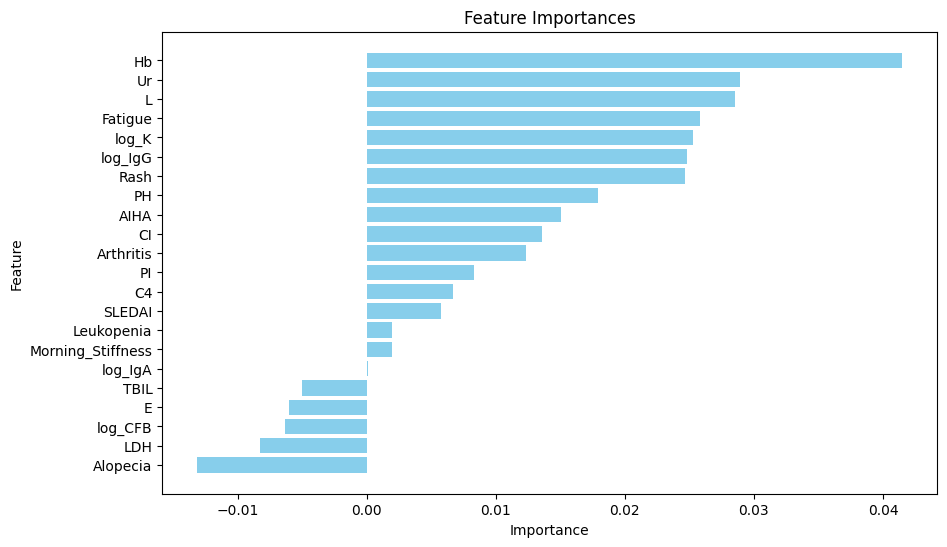

In [ ]:
feature_importances = np.zeros(X_test.shape[1])

for i in range(X_test_tensor.shape[1]):
    X_test_permuted = copy.deepcopy(X_test_tensor)
    X_test_permuted[:, i] = X_test_permuted[:, i][torch.randperm(len(X_test_permuted))]
    permuted_accuracy = evaluate_model(model, X_test_permuted, y_test_tensor)
    feature_importances[i] = original_auc - permuted_accuracy

# Feature importance ranking
importance_ranking = np.argsort(feature_importances)[::-1]

# Sort the features by their importance
sorted_idx = np.argsort(feature_importances)
sorted_importances = feature_importances[sorted_idx]
sorted_features = [X_test.columns[i] for i in sorted_idx]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()
